![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [200]:
import warnings
warnings.filterwarnings('ignore')

In [201]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [202]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [203]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [204]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [205]:
bikes.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


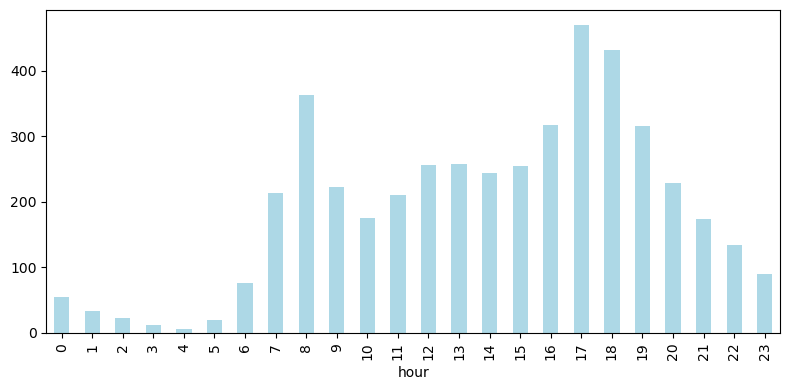

In [206]:
import matplotlib.pyplot as plt

summary_hour = bikes.groupby('hour')['total'].describe()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

summary_hour['mean'].plot(kind='bar', color='lightblue')

plt.tight_layout()
plt.show()

## Análisis descriptivo

1. Teniendo en cuenta que season toma los valores de: 1:winter, 2:spring, 3:summer, 4:fall. Podemos ver que en las estaciones más cálidas, como lo son verano y primavera, se alquilan más bicicletas. En cambio en otoño e invierno es menor la cantidad de alquileres.

2. Por el promedio de bicicletas alquiladas cada hora podemos sugerir una distribución normal. Donde en las horas de la mitad del día se encuentra mayor cantidad de bibicletas alquiladas. Pero al graficar, nos damos cuentas que tiene subídas en las primeras horas de la mañana -probablemente cuando las personas van a trabajar- vuelve y baja, y sube de nuevo en las horas cuando se termina la jornada laboral. 

3. Podemos observar que la ciudad de la que tenemos datos, la mayor parte del tiempo se encuentra fresca < 26°C

4. No tenemos datos faltantes 

5. A pesar de que el percentill 75% de total es 284, podemos ver un máximo de 977. Por lo que podríamos suponer datos atípicos. 

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

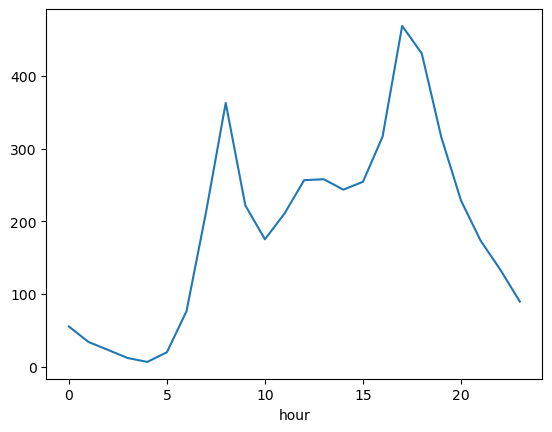

In [207]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

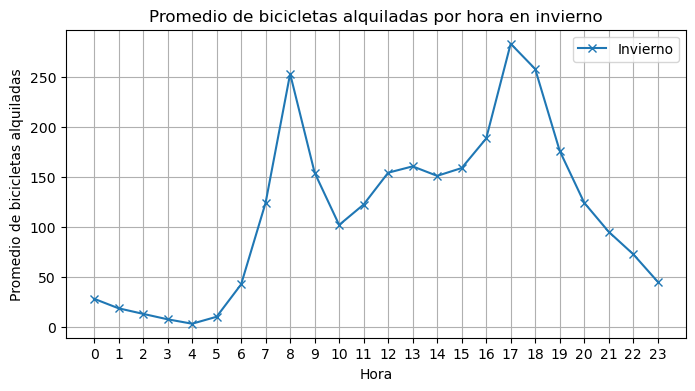

In [208]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos
winter_bikes = bikes[bikes['season'] == 1 ]
winter_mean = winter_bikes.groupby('hour').total.mean()

plt.figure(figsize=(8, 4))
winter_mean.plot(label='Invierno', marker='x')
plt.xlabel('Hora')
plt.ylabel('Promedio de bicicletas alquiladas')
plt.title('Promedio de bicicletas alquiladas por hora en invierno')
plt.xticks(range(24)) # para ver márgenes de líneas en cada una de las horas
plt.legend()
plt.grid(True)
plt.show()

## Análisis 

Aunque en su forma se vea igual al gráfico en el que usamos todas las seasons, la escala es diferente. Va de 0-300 aproximadamente. Lo que muestra que las tendencias de aquiler siguen la misma forma, pero en menor proporción durante el invierno.

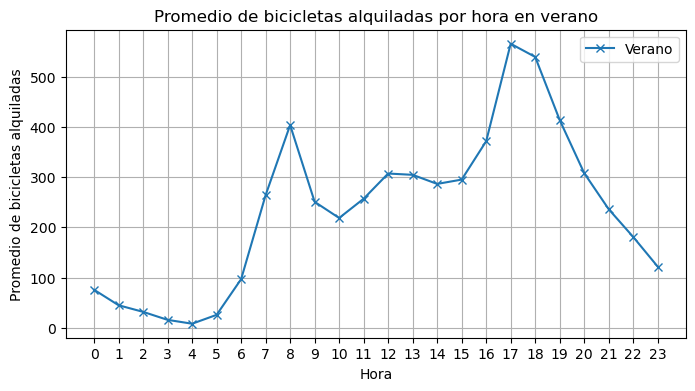

In [209]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
summer_bikes = bikes[bikes['season'] == 3 ]

summer_mean = summer_bikes.groupby('hour').total.mean()

plt.figure(figsize=(8, 4))
summer_mean.plot(label='Verano', marker='x')
plt.xlabel('Hora')
plt.ylabel('Promedio de bicicletas alquiladas')
plt.title('Promedio de bicicletas alquiladas por hora en verano')
plt.xticks(range(24)) # para ver márgenes de líneas en cada una de las horas
plt.legend()
plt.grid(True)
plt.show()

## Análisis 

De manera similar al invierno, en verano la escala es diferente. Va de 0-550 aproximadamente. Lo que muestra que las tendencias de aquiler siguen una forma similar, pero en mayor proporción durante el verano que al tener en cuenta otras estaciones. Al ser un promedio se puede ver afectado por estos datos. Como vimos, tenemos datos atípicos

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [210]:
from sklearn.model_selection import train_test_split

X = bikes[['season', 'hour']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
                                                    
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [211]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, drop='first')
encoder.fit(X_train['season'].to_numpy().reshape(-1, 1))
encoded_seasons = encoder.transform(X_train['season'].to_numpy().reshape(-1, 1))

# 2:spring, 3:summer, 4:fall
X_encoded_train = pd.DataFrame(encoded_seasons, columns=['season_spring', 'season_summer', 'season_fall'])

X_encoded_train['hour'] = X_train[['hour']]

X_encoded_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293 entries, 0 to 7292
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season_spring  7293 non-null   float64
 1   season_summer  7293 non-null   float64
 2   season_fall    7293 non-null   float64
 3   hour           7293 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 199.5 KB


In [212]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_encoded_train)
X_encoded_train_scaled = scaler.transform(X_encoded_train)
X_encoded_train_scaled

array([[-0.58151968,  1.73220915, -0.57983078,  1.51564175],
       [-0.58151968, -0.57729749,  1.7246411 , -0.94215407],
       [-0.58151968, -0.57729749, -0.57983078, -1.6650352 ],
       ...,
       [-0.58151968, -0.57729749, -0.57983078, -1.0867303 ],
       [-0.58151968, -0.57729749,  1.7246411 , -0.21927295],
       [-0.58151968, -0.57729749, -0.57983078, -1.37588275]])

In [213]:
regression = LinearRegression()

regression.fit(X_encoded_train_scaled, y_train)

LinearRegression()

In [214]:
encoded_test = encoder.transform(X_test['season'].to_numpy().reshape(-1, 1))

X_encoded_test = pd.DataFrame(encoded_test, columns=['season_spring', 'season_summer', 'season_fall'])

X_encoded_test['hour'] = X_test[['hour']]

X_encoded_test_scaled = scaler.transform(X_encoded_test)

prediction = regression.predict(X_encoded_test_scaled)

In [215]:
regression.coef_

array([41.16841342, 51.66135539, 36.23977149, 72.66349004])

In [216]:
regression.intercept_

190.06650212532566

In [217]:
from sklearn.metrics import mean_squared_error

MSE_reg = mean_squared_error(y_test, prediction, squared=False)
print('RMSE regresión lineal:')
print(MSE_reg)

RMSE regresión lineal:
161.45510643212268


## Interpretación de los coeficientes

- Podemos ver que se le da un peso mayor a la hora del día al momento de predecir el número de bicicletas alquiladas para una hora en específico. 

- A la season que más le da importancia es al verano. 

- El intercepto nos dice que mínimo se alquila 190 bicicletas por día. Lo que contradice nuestra estadística descriptiva de min en el punto anterior. Por ende sabemos que aunque ese sea el mínimo, puede ser un data atípico. Ya que nuestro modelo está predispuesto a dar otro resultado como mínimo. 

## Limitaciones

- Como su nombre lo dice, este modelo asume linealidad entre las variables independientes y la dependiente. Como vimos en los gráficos, puede que no sea el mejor modelo dado el comportamiento no lineal que tiene durante el día.

- Al inicio vimos que contamos con datos atípicos, esto puede tener un gran impacto en los resultados, dado que los coeficientes se calculan utilizandolos y podría darle más peso a algunos coeficientes y sesgar la decisión hacía ese mismo.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [218]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [219]:
X = bikes[['season', 'hour']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Max Depth toma el valor de 4 para que tenga al menos 6 nodos finales
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10) 
tree

{'y_pred': 1,
 'y_prob': 190.0145305003427,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 7293,
 'gain': 18166.26384419392,
 'sl': {'y_pred': 1,
  'y_prob': 54.571369466280515,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 2415,
  'gain': 6675.562432832958,
  'sl': {'y_pred': 1,
   'y_prob': 32.78544423440454,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 2114,
   'gain': 646.4996860910196,
   'sl': {'y_pred': 1,
    'y_prob': 25.476872246696036,
    'level': 3,
    'split': [1, 2.0],
    'n_samples': 1814,
    'gain': 394.2935575438278,
    'sl': {'y_pred': 1,
     'y_prob': 44.98863636363637,
     'level': 4,
     'split': -1,
     'n_samples': 614,
     'gain': 294.12861366532843},
    'sr': {'y_pred': 1,
     'y_prob': 15.43594009983361,
     'level': 4,
     'split': -1,
     'n_samples': 1200,
     'gain': 42.74934344193821}},
   'sr': {'y_pred': 1,
    'y_prob': 76.51986754966887,
    'level': 3,
    'split': [0, 2.0],
    'n_samples': 300,
    'gain': 673.9190651072

In [220]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [221]:
prediction = tree_predict(X_test, tree)

MSE_manual_tree = mean_squared_error(y_test, prediction, squared=False)
print('RMSE árboles de decisión manual:')
print(MSE_manual_tree)

RMSE árboles de decisión manual:
266.8288858573219


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

Text(0, 0.5, 'Accuracy')

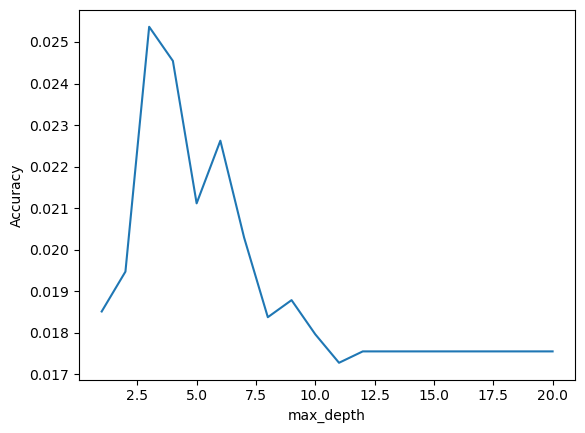

In [222]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

X = bikes[['season', 'hour']]
y = bikes['total']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [223]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.025365954488227444, 3)

In [224]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=3, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [225]:
prediction = clf.predict(X_test)

MSE_tree = mean_squared_error(y_test, prediction, squared=False)
print('RMSE árboles de decisión:')
print(MSE_tree)

RMSE árboles de decisión:
153.42405249212405


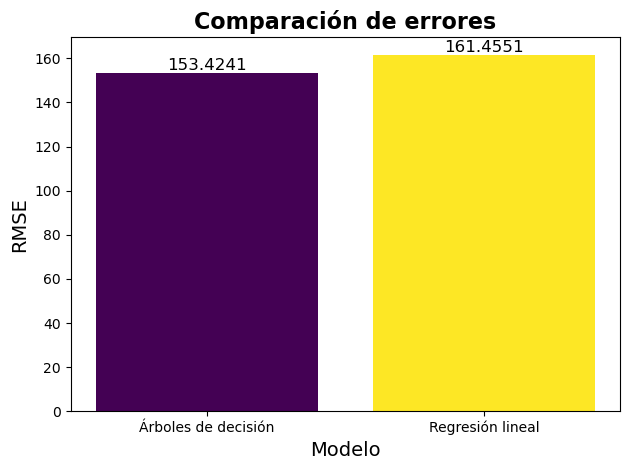

In [226]:
# Errores
models = ['Regresión lineal', 'Árboles de decisión']
errors = [MSE_reg, MSE_tree]

# Sorting
sorted_indices = np.argsort(errors)
sorted_models = [models[idx] for idx in sorted_indices]
sorted_errors = [errors[idx] for idx in sorted_indices]

# Colores
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_models)))

# Crear el plot
fig, ax = plt.subplots()
ax.set_title("Comparación de errores", fontsize=16, fontweight='bold')
ax.set_xlabel("Modelo", fontsize=14)
ax.set_ylabel("RMSE", fontsize=14)
ax.bar(sorted_models, sorted_errors, color=colors)

# Etiquetas de datos
for i, v in enumerate(sorted_errors):
    ax.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontsize=12, color='black')

# Layout
plt.tight_layout()

# Mostrar el plot
plt.show()

## Conclusiones

Al comparar ambos modelos podemos ver un mejor desempeño en los árboles de decisión. Esto puede deberse a las particularidades de este modelo con respecto a la regresión lineal, como:

- No verse afectado por los datos atípicos
- Aceptan por naturaleza variables categóricas
- No supone linealidad

Estas son características que en nuestro ejercicio hacen que un árbol de decisión tenga un mejor desempeño. 

Esto no significa que siempre los árboles de decisión tengan un mejor desempeño que la regresión lineal. Depende de la naturaleza del problema y del comportamiento de los datos. 

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [227]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [228]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [229]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

Text(0, 0.5, 'Accuracy')

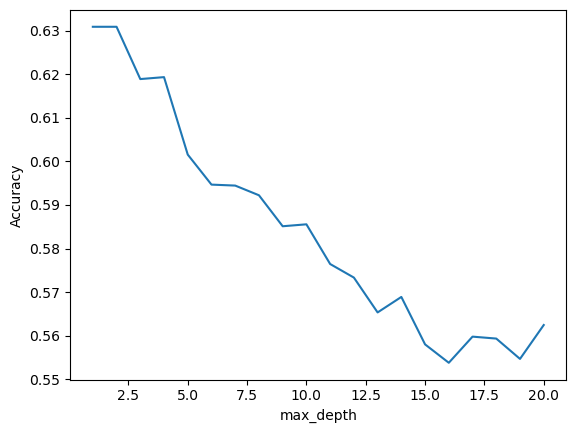

In [230]:
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [231]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.6308888888888888, 2)

In [232]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [237]:
from sklearn.metrics import accuracy_score, f1_score

tree_prediction = clf.predict(X_test)

tree_accuracy = accuracy_score(y_test, tree_prediction)
tree_f1_score = f1_score(y_test, tree_prediction)

print("Accuracy:", tree_accuracy)
print("F1-score:", tree_f1_score)

Accuracy: 0.6213333333333333
F1-score: 0.6167341430499326


In [238]:
# Regresión logística
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

logistic_model = LogisticRegression(random_state=1)
logistic_model.fit(X_scaled_train, y_train)

logistic_prediction = logistic_model.predict(X_scaled_test)

logistic_accuracy = accuracy_score(y_test, logistic_prediction)
logistic_f1_score = f1_score(y_test, logistic_prediction)

print("Accuracy:", logistic_accuracy)
print("F1-score:", logistic_f1_score)

Accuracy: 0.64
F1-score: 0.6296296296296297


## Análisis 

* Accuracy: Para la métrica Accuracy, el modelo de Regresión logística es superior al modelo de Árboles de decisión
* F1-score: Para la métrica de F1-score, el modelo de Regresión logística es superior al modelo de Árboles de decisión. El F1-score es una métrica que pondera accuracy y la recuperación, lo que la convierte en una medida más completa del rendimiento del modelo.
* Robustez: El modelo de regresión logística es más robusto a valores atípicos que el modelo de árboles de decisión. Puede que en nuestro caso existan datos atípicos en la base de datos usada.
* Interpretabilidad: El modelo de árboles de decisión es más fácil de interpretar que el modelo de regresión logística. Esto puede ser importante si es necesario comprender cómo funciona el modelo y por qué toma ciertas decisiones.

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [243]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Parámetros
max_depth = 2
min_samples_leaf = 4
random_state = 1

# Definición de los modelos
tree_with_depth = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
tree_with_leaf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=random_state)
logistic = LogisticRegression(random_state=random_state)

# Entrenamiento de los modelos
tree_with_depth.fit(X_train, y_train)
tree_with_leaf.fit(X_train, y_train)
logistic.fit(X_train, y_train)

# Creación del ensamble
tree_depth_bagged = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=100, random_state=random_state)
tree_leaf_bagged = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=min_samples_leaf), n_estimators=100, random_state=random_state)
logistic_bagged = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, random_state=random_state)

# Entrenamiento de los modelos
tree_depth_bagged.fit(X_train, y_train)
tree_leaf_bagged.fit(X_train, y_train)
logistic_bagged.fit(X_train, y_train)

# Ensamble con VotingClassifier 
ensemble_clf = VotingClassifier(estimators=[
    ('tree_depth', tree_depth_bagged), 
    ('tree_leaf', tree_leaf_bagged), 
    ('logistic', logistic_bagged)], 
 voting='hard') # Voto mayoritario

ensemble_clf.fit(X_train, y_train)

# Evaluación de los modelos
models = [tree_with_depth, tree_with_leaf, logistic]
names = ["Arbol con profundidad", "Arbol con hojas mínimas", "Regresión logística"]

for model, name in zip(models, names):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Modelo: {name}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print()
    
# Evaluación del ensamble
y_pred = ensemble_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Ensamble de Votación Mayoritaria")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-Score: {f1:.3f}")

Modelo: Arbol con profundidad
Accuracy: 0.645
F1-Score: 0.645

Modelo: Arbol con hojas mínimas
Accuracy: 0.550
F1-Score: 0.548

Modelo: Regresión logística
Accuracy: 0.614
F1-Score: 0.610

Ensamble de Votación Mayoritaria
Accuracy: 0.649
F1-Score: 0.648


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [247]:
# Parámetros
max_depth = 2
min_samples_leaf = 4
random_state = 1

# Definición de los modelos
tree_with_depth = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state)
tree_with_leaf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=random_state)
logistic = LogisticRegression(random_state=random_state)

# Entrenamiento de los modelos
tree_with_depth.fit(X_train, y_train)
tree_with_leaf.fit(X_train, y_train)
logistic.fit(X_train, y_train)

# Creación del ensamble
tree_depth_bagged = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=100, random_state=random_state)
tree_leaf_bagged = BaggingClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=min_samples_leaf), n_estimators=100, random_state=random_state)
logistic_bagged = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, random_state=random_state)

# Entrenamiento de los modelos
tree_depth_bagged.fit(X_train, y_train)
tree_leaf_bagged.fit(X_train, y_train)
logistic_bagged.fit(X_train, y_train)

# Calculando los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(3)
y_pred_all_ = np.zeros((X_test.shape[0], 3))

# Calculando errores y predicciones de cada modelo
models = [tree_depth_bagged, tree_leaf_bagged, logistic_bagged]
for i, model in enumerate(models):
    oob_sample = ~np.asarray(model.estimators_samples_)
    y_pred_ = model.estimators_[0].predict(X_train.values[oob_sample[0]])
    errors[i] = 1 - accuracy_score(y_pred_, y_train.values[oob_sample[0]])
    y_pred_all_[:, i] = model.predict(X_test)

# Calculando pesos alpha
alpha = (1 - errors) / (1 - errors).sum()

# Predicción final del ensamble ponderado
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(int)

# Evaluación del ensamble
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Ensamble de Votación Ponderada")
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-Score: {f1:.3f}")

Ensamble de Votación Ponderada
Accuracy: 0.649
F1-Score: 0.648


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

## Análisis 

### Votación mayoritaria
* Los árboles de decisión funcionan mejor para este problema. De forma individual vemos que los modelos de árboles funcionan mejor que la regresión logística para este problema.
* La Votación Mayoritaria ha mostrado mejorar ligeramente los resultados del mejor modelo individual, esto implica que está aprovechando la información de los tres modelos diferentes.
* Aunque se observa una mejora, esta es relativamente pequeña. Esto podría indicar que los modelos base son bastante similares o que se necesita buscar estrategias de ensamblado más sofisticadas.

#### Ventajas
* Simpleza: Es un método relativamente intuitivo de combinar modelos, es fácil de implementar y entender.
* Robustez: Ayuda a reducir el riesgo de overfitting y puede manejar mejor outliers o ruido en los datos al corregir errores propios de cada modelo.

#### Desventajas
* Rendimiento no siempre garantizado: Si los modelos base tienen un rendimiento similar o son poco diversos, su combinación puede que no mejore significativamente los resultados.
* Pérdida de interpretabilidad: Al combinar varios modelos, puede resultar más difícil comprender exactamente cómo se toman las decisiones finales, comprometiendo la capacidad de interpretación.

### Votación ponderada
* La Votación Ponderada no presenta una mejora significativa en la capacidad predictiva en comparación con la Votación Mayoritaria. Ambas obtuvieron un Accuracy y F1-Score de 0.649 y 0.648 respectivamente.
* Sin embargo, la Votación Ponderada sí supera a los modelos individuales (Arbol con profundidad, Arbol con hojas mínimas y Regresión logística) en ambas métricas.

#### Ventajas
* Robustez: Ayuda a reducir el riesgo de overfitting y puede manejar mejor outliers o ruido en los datos al corregir errores propios de cada modelo.
* Flexibilidad: Permite ajustar la importancia de cada modelo individual mediante las ponderaciones. Aunque en este caso no se hizo muy evidente su mejoría. 

#### Desventajas
* Complejidad: El cálculo de las ponderaciones puede ser complejo y requiere de una selección cuidadosa de la metodología.
* Pérdida de interpretabilidad: Al combinar varios modelos, puede resultar más difícil comprender exactamente cómo se toman las decisiones finales, comprometiendo la capacidad de interpretación.

### Conclusiones

De forma general podemos ver la mejora del rendimiento de los modelos utilizando ensamblajes de modelos que de por sí tienen un buen desempeño. Esto nos lleva a resaltar que:

* Los métodos de ensamblaje como la Votación Ponderada y la Votación Mayoritaria pueden mejorar la precisión y robustez de las predicciones en comparación con los modelos individuales.
* Combinar las predicciones de diferentes modelos ayuda a mitigar el sesgo individual y obtener una perspectiva más completa del problema.